In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/16h5/s_yaw_16h5_5m_360_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,16.274787
1,0.066075,17.161502
2,0.131294,16.684416
3,0.185900,16.785167
4,0.241322,16.309673
...,...,...
2614,120.679974,-41.899699
2615,121.679065,-33.711519
2616,122.877935,-1.498250
2617,124.378354,11.646883


In [5]:
# remove some rows due to a video error
df = df[~df.relative_time.between(66, 70, inclusive=True)].reset_index()

/tmp/ipykernel_19905/1001537679.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df = df[~df.relative_time.between(66, 70, inclusive=True)].reset_index()


<AxesSubplot:xlabel='relative_time'>

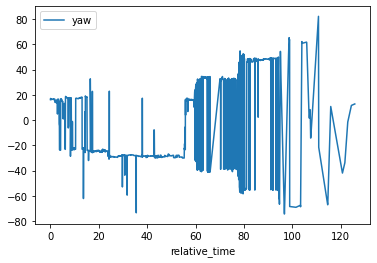

In [6]:
# initial graph
df.plot(x='relative_time', y=target)

In [7]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [8]:
# the amount of data points we are left with
len(x[peaks])

395

In [9]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

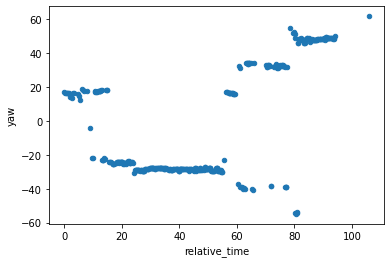

In [10]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [11]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,index,relative_time,yaw,true_yaw
1,1,0.066075,17.161502,45
3,3,0.185900,16.785167,45
10,10,0.580133,16.709485,45
15,15,0.902321,16.663585,45
18,18,1.092935,16.697657,45
...,...,...,...,...
2435,2555,93.545810,48.649135,75
2438,2558,93.645546,48.657698,75
2441,2561,93.744840,48.940401,75
2455,2575,94.210551,49.970686,75


In [12]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [13]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [14]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,index,relative_time,yaw,true_yaw,error
1,1,0.066075,17.161502,45,27.838498
3,3,0.185900,16.785167,45,28.214833
142,142,8.961539,-4.310269,30,34.310269
154,154,9.677054,-21.958784,15,36.958784
160,160,10.075511,-21.888217,15,36.888217
1611,1611,60.544557,-37.422053,0,37.422053
1619,1619,60.810608,32.434380,60,27.565620
1624,1624,60.976989,-39.055025,0,39.055025
1631,1631,61.210300,31.569248,60,28.430752
2014,2134,78.377357,54.851442,75,20.148558


In [15]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,20.0,42.943019,6.813458,37.422053,38.656775,39.397288,43.943240,54.850811
15,212.0,42.396730,2.018437,36.888217,42.398552,43.079552,43.725452,45.859866
30,1.0,34.310269,NaN,34.310269,34.310269,34.310269,34.310269,34.310269
45,49.0,28.248660,1.246421,26.198301,27.294519,28.214833,28.624357,32.292156
60,41.0,27.123573,0.900545,25.586611,26.559057,27.159137,27.726293,28.875982
75,72.0,26.240270,2.083624,13.226960,26.075475,26.475611,27.031754,29.140443


In [16]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

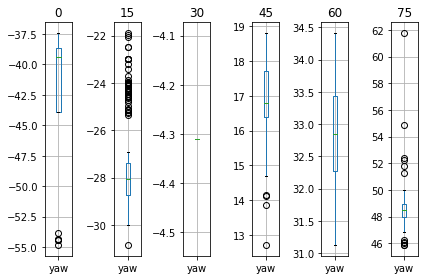

In [17]:
box_plotter(target)

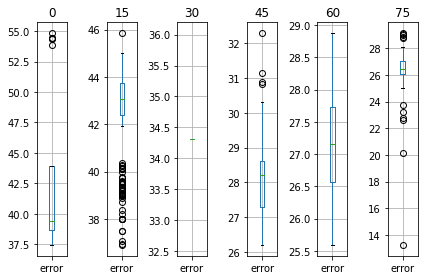

In [18]:
box_plotter('error')

In [19]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/5m_16h5_360.csv')